
# Traffic Source quality analysis
The problem - estimation of internet traffic from a small sample of users (traffic source). In this assignment, you are asked to evaluate the quality of three potential such sources.

Provided input

Attached are two data files: Learning set contains actual traffic measurements for each site, Sources contain traffic measurement from a sample of internet users.
-	SourceID - Identifies the source which sample the row belongs
-	Site - the domain name of the site (for example google.com). 
-	Number of Visits - an Internet traffic metric representing the number of visits to each site for that source. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.float_format', '{:.3f}'.format)

## Explore The Learning Set 

contains actual traffic measurements for each site

In [2]:
# Load the data 
LSet_df = pd.read_csv("LearningSet.csv", sep="\t")
rows, columns = LSet_df.shape
print(f"The learning set has {rows} rows and {columns} columns")
LSet_df.head(8)

The learning set has 9699 rows and 2 columns


,Site,Visits
0,06880danwoog.com*,36280
1,0800-horoscope.com*,120690
2,10000boatnames.com*,6858
3,100bestvacations.com*,12891
4,100stuartstreet.com*,9758
5,1013.com*,77314
6,1015store.com*,285488
7,101kgb.com*,76934


In [3]:
# Look at the top sites 
LSet_df.nlargest(10, 'Visits')

,Site,Visits
8738,tumblr.com*,261974470
4284,huffingtonpost.com*,245887198
5115,linkedin.com*,232618922
9435,wordpress.com*,105976942
2517,drudgereport.com*,97594902
9318,wikia.com*,76239916
6953,recipecorner.com*,73906493
7158,rss2search.com*,73083711
1325,buzzfeed.com*,71304869
9589,yelp.com*,69826928


In [4]:
# and the weak sites..
LSet_df.nsmallest(10, 'Visits')

,Site,Visits
5095,liferemix.net*,5001
2898,ey.jobs*,5002
2973,farmtalknewspaper.com*,5002
4799,kidventurous.com*,5002
3577,gethrassistantjobs.com*,5005
9233,westfargopioneer.com*,5006
1041,blackweb20.com*,5020
6806,pups-seeking-homes.com*,5020
1161,bountyfishing.com*,5021
5141,live4ever.uk.com*,5022


### Descriptive statistics

In [5]:
LSet_df.describe()

,Visits
count,9699.000
mean,649315.583
std,5558450.522
min,5001.000
25%,14244.500
50%,41195.000
75%,173195.500
max,261974470.000


- There are 9699 sites.
- The range of visits is between 5,001 - 261,974,470 (very wide)
- The mean (649,315) is much larger than the median (41,195)

### Data Distribution

In [6]:
LSet_df['Visits'].quantile(0.9)

739297.8000000006

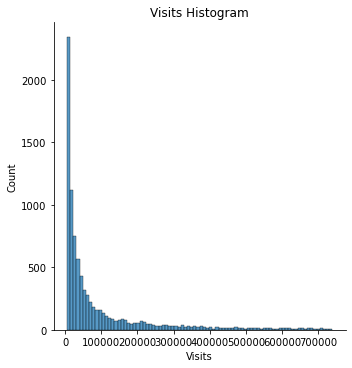

In [7]:
# Because the wide range of 'visits', the plot shows up to the 90th percentile
flt = LSet_df['Visits'] < LSet_df['Visits'].quantile(0.9)
g = sns.displot(LSet_df.loc[flt]['Visits'])
g = plt.title("Visits Histogram")

In [8]:
# the border of each percentile
percentile_border = LSet_df['Visits'].quantile(np.linspace(0.1,1,10))
percentile_border

0.100        7650.400
0.200       11404.400
0.300       17648.200
0.400       27018.600
0.500       41195.000
0.600       66966.600
0.700      120437.200
0.800      254711.200
0.900      739297.800
1.000   261974470.000
Name: Visits, dtype: float64

In [9]:
# add the percentile to each row

percentile_border = percentile_border.to_list()
percentile_names = ['p10','p20','p30','p40','p50','p60','p70','p80','p90','p100']

def percentile(x, percentile_border, percentile_names):
    for i in range(len(percentile_names)):
        if x <= percentile_border[i]:
            return percentile_names[i]
    
LSet_df['percentile'] = LSet_df['Visits'].apply(percentile, args=(percentile_border,percentile_names))
LSet_df

,Site,Visits,percentile
0,06880danwoog.com*,36280,p50
1,0800-horoscope.com*,120690,p80
2,10000boatnames.com*,6858,p10
3,100bestvacations.com*,12891,p30
4,100stuartstreet.com*,9758,p20
...,...,...,...
9694,zurinstitute.com*,28788,p50
9695,zvents.com*,740008,p100
9696,zx6r.com*,57444,p60
9697,zybez.net*,1237033,p100


In [10]:
# the range of each percentile
xdiff = list(np.diff(percentile_border))
xdiff.insert(0, percentile_border[0] - LSet_df['Visits'].min())
xdiff = list(map(round,xdiff))
xdiff

[2649, 3754, 6244, 9370, 14176, 25772, 53471, 134274, 484587, 261235172]

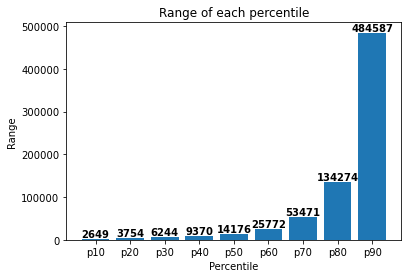

In [11]:
bar = plt.bar(x = percentile_names[:-1], height=xdiff[:-1])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, int(height), ha='center', va='bottom',fontweight='bold', size=10,color='black')
bar = plt.title('Range of each percentile')
bar = plt.xlabel('Percentile')
bar = plt.ylabel('Range')

### Log Scale
to handle the wide range more easily, we use log scale

In [12]:
LSet_df['log_visit'] = np.log(LSet_df['Visits'])

In [13]:
LSet_df['log_visit'].describe()

count   9699.000
mean      10.982
std        1.794
min        8.517
25%        9.564
50%       10.626
75%       12.062
max       19.384
Name: log_visit, dtype: float64

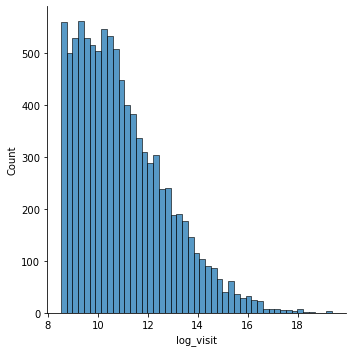

In [14]:
g = sns.displot(LSet_df['log_visit'])

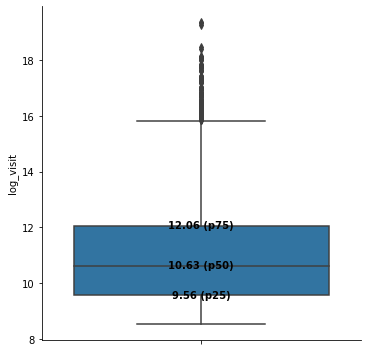

In [15]:
box_plot = sns.catplot(y = 'log_visit', data=LSet_df, kind='box' )
ax = box_plot.ax
lines = ax.get_lines()
# 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
p25 = round(lines[0].get_ydata()[0],2)
p75 = round(lines[1].get_ydata()[0],2)
p50 = round(lines[4].get_ydata()[0],2)
t = ax.text(0, p25, f'{p25} (p25)', ha='center', va='center', fontweight='bold', size=10,color='black')
t = ax.text(0, p75, f'{p75} (p75)', ha='center', va='center', fontweight='bold', size=10,color='black')
t = ax.text(0, p50, f'{p50} (p50)', ha='center', va='center', fontweight='bold', size=10,color='black')


### conclusion 
- 'visits' have wide range of values (5,000 - 261,974,470)
- Most sites have a small number of visits, and as the number of visits increases, the number of those sites decreases 
- Log scaling reduce this range to (8.517 - 19.384) and enables us to plot all the dots.

## Explore The Sources Data
Sources contain traffic measurement from 3 internet users

In [16]:
sources_df = pd.read_csv("Sources.csv", sep="\t")
print(sources_df.shape)
sources_df.head()

(18652, 3)


,SourceID,Site,Visits
0,1,06880danwoog.com*,745
1,1,0800-horoscope.com*,885
2,1,10000boatnames.com*,74
3,1,100bestvacations.com*,105
4,1,100stuartstreet.com*,187


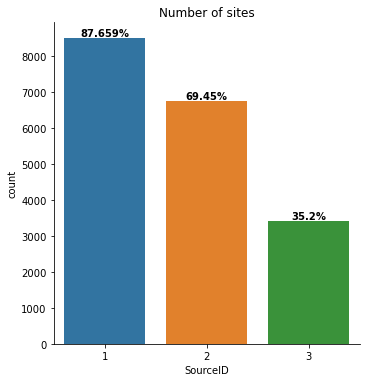

In [17]:
# how many sites each source visit 
total_sites = LSet_df.shape[0]
g = sns.catplot(x='SourceID', data = sources_df, kind='count')

for rect in g.ax.patches:
    height = rect.get_height()
    percentage = round(height/total_sites * 100.0,3)
    x = rect.get_x() + rect.get_width()/2.0
    plt.text(x, height, f'{percentage}%', ha='center', va='bottom',fontweight='bold', size=10,color='black')

g = plt.title('Number of sites')

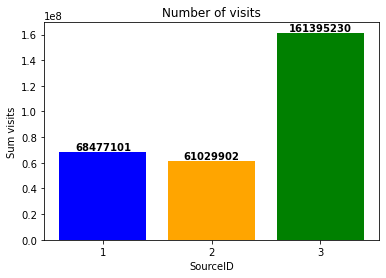

In [18]:
# how many visits each source has
source_visit_sum = sources_df.groupby(['SourceID'])['Visits'].sum().to_dict()

bar = plt.bar(x = list(map(str,source_visit_sum.keys())), height=source_visit_sum.values(),color = ['blue','orange','green'])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, int(height), ha='center', va='bottom',fontweight='bold', size=10,color='black')
bar = plt.title('Number of visits')
bar = plt.xlabel('SourceID')
bar = plt.ylabel('Sum visits')

- user 1 visit most internet sites (87%), although his total traffic is not the highest.
- user 3 has the most traffic but visit only (35%) of sites.
- user 2 has the least traffic, but he visits (69%) of sites.

###  Descriptive statistics

In [19]:
pivot = sources_df.pivot_table(index=['Site'],columns=['SourceID'], values='Visits')
pivot.columns = ['SourceID_1','SourceID_2','SourceID_3']
pivot.head(8)

,SourceID_1,SourceID_2,SourceID_3
Site,,,
06880danwoog.com*,745.000,516.000,nan
0800-horoscope.com*,885.000,1149.000,930.000
10000boatnames.com*,74.000,nan,nan
100bestvacations.com*,105.000,nan,nan
100stuartstreet.com*,187.000,nan,nan
1013.com*,1251.000,nan,nan
1015store.com*,3134.000,2404.000,1615.000
101kgb.com*,1449.000,858.000,1374.000


In [20]:
pivot.describe()

,SourceID_1,SourceID_2,SourceID_3
count,8502.000,6736.000,3414.000
mean,8054.234,9060.259,47274.525
std,75771.271,44879.284,1201798.796
min,10.000,21.000,23.000
25%,171.000,301.000,449.000
50%,520.000,949.000,1945.000
75%,2008.000,3541.000,7794.500
max,3713883.000,1341459.000,60908912.000


## Data Distribution

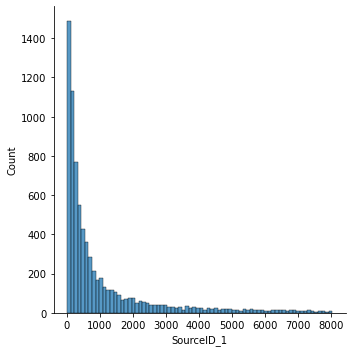

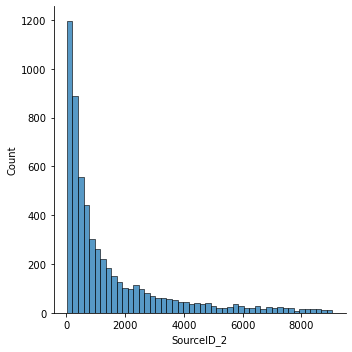

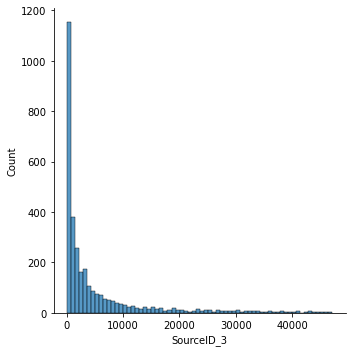

In [21]:
for i, column in enumerate(pivot.columns):
    flt = pivot[column] < pivot[column].mean() 
    sns.displot(pivot.loc[flt][column])

## Log scale

In [22]:
sources_df['log_Visits'] = np.log(sources_df['Visits'])

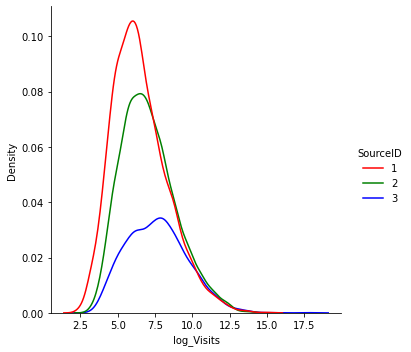

In [23]:
g = sns.displot(data=sources_df, x="log_Visits", hue="SourceID", palette=['r','g','b'], kind = 'kde')

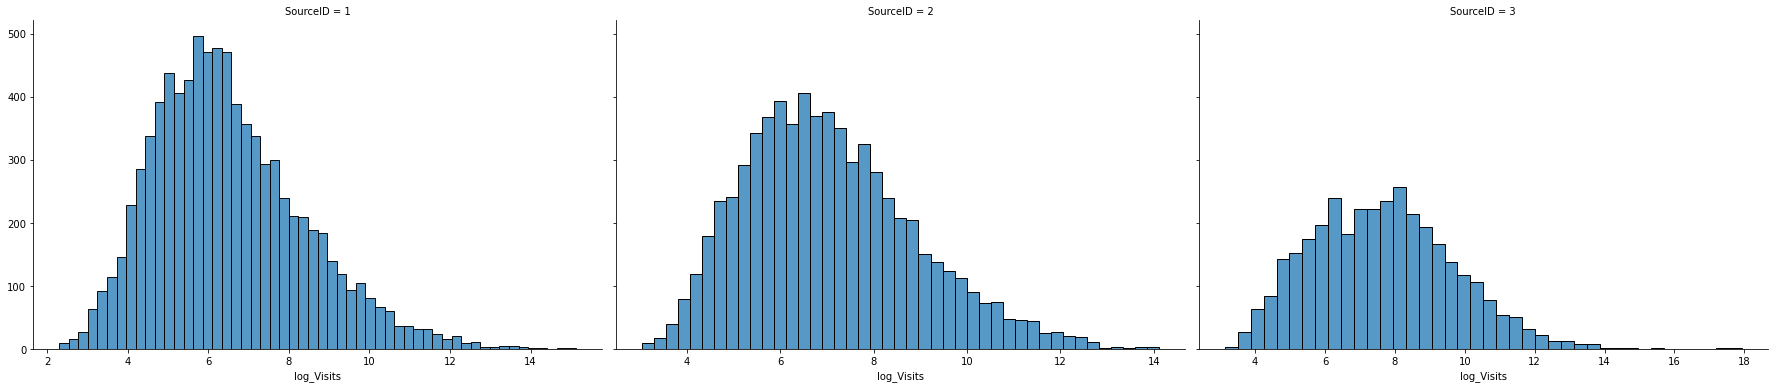

In [24]:
g = sns.FacetGrid(data=sources_df, col='SourceID', height=5.5, aspect=1.5, sharex=False)
g = g.map(sns.histplot, 'log_Visits')

## Correlation 

**Linear Correlation - Pearson**

In [25]:
mergedDf = LSet_df.merge(pivot, left_on='Site' ,right_index=True)
mergedDf = mergedDf.drop(columns = ['log_visit'])
mergedDf.head()

,Site,Visits,percentile,SourceID_1,SourceID_2,SourceID_3
0,06880danwoog.com*,36280,p50,745.000,516.000,nan
1,0800-horoscope.com*,120690,p80,885.000,1149.000,930.000
2,10000boatnames.com*,6858,p10,74.000,nan,nan
3,100bestvacations.com*,12891,p30,105.000,nan,nan
4,100stuartstreet.com*,9758,p20,187.000,nan,nan


In [26]:
mergedDf.corr(method='pearson')[['Visits']]

,Visits
Visits,1.000
SourceID_1,0.939
SourceID_2,0.906
SourceID_3,0.248


In [27]:
mergedDf_log = mergedDf.copy()
mergedDf_log['Visits'] = np.log(mergedDf_log['Visits'])
mergedDf_log['SourceID_1'] = np.log(mergedDf_log['SourceID_1'])
mergedDf_log['SourceID_2'] = np.log(mergedDf_log['SourceID_2'])
mergedDf_log['SourceID_3'] = np.log(mergedDf_log['SourceID_3'])
mergedDf_log.head()

,Site,Visits,percentile,SourceID_1,SourceID_2,SourceID_3
0,06880danwoog.com*,10.499,p50,6.613,6.246,nan
1,0800-horoscope.com*,11.701,p80,6.786,7.047,6.835
2,10000boatnames.com*,8.833,p10,4.304,nan,nan
3,100bestvacations.com*,9.464,p30,4.654,nan,nan
4,100stuartstreet.com*,9.186,p20,5.231,nan,nan


In [28]:
# Pearson correlation after log scale the data.
mergedDf_log.corr(method='pearson')[['Visits']]

,Visits
Visits,1.000
SourceID_1,0.947
SourceID_2,0.967
SourceID_3,0.982


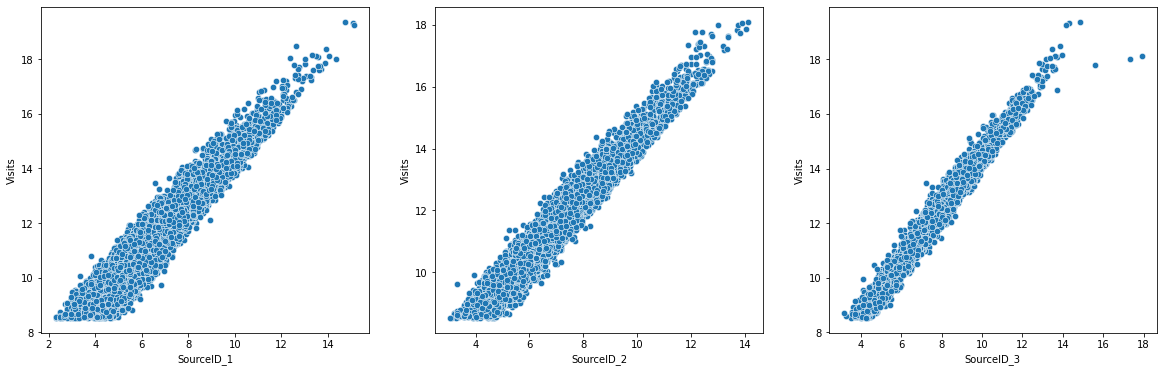

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 6))
for i, column in enumerate(['SourceID_1', 'SourceID_2', 'SourceID_3']):
    sns.scatterplot(data=mergedDf_log, x=column, y='Visits', edgecolors='white', s = 40 , ax=axes[i])

**Rank Correlation - Spearman and Kendall**

In [30]:
mergedDf.corr(method='spearman')[['Visits']]

,Visits
Visits,1.000
SourceID_1,0.935
SourceID_2,0.963
SourceID_3,0.983


In [31]:
mergedDf.corr(method='kendall')[['Visits']]

,Visits
Visits,1.000
SourceID_1,0.781
SourceID_2,0.832
SourceID_3,0.884


### conclusion 
There are similarities and differences between the users.

Differences:

- The amount of traffic.
- The range of sites.

Similarities:

- The distribution of their visits.
- The hige correletion to the learning set


## Estimate the learning set, Linear regression

In [32]:
from sklearn import linear_model
from sklearn.metrics import r2_score

# build linear regression for each user
regres = {}
for source in ['SourceID_1','SourceID_2','SourceID_3']:
    source_Learning = mergedDf_log.loc[:,['Site','Visits',source]].dropna()
    X = source_Learning[[source]]
    Y = source_Learning['Visits']
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    
    regres[source] = [regr, X, Y]

In [33]:
# show predictions of a Linear regression model
def show_results(regr, x, y, n_sample=10, indexes=None):
    if indexes:
        pass
    else:
        indexes = np.random.choice(x.index.to_list(), n_sample)
    x_sample = x.loc[indexes].to_numpy()
    y_sample = y.loc[indexes]
    y_hat = (x_sample * regr.coef_).sum(axis=1) + regr.intercept_
    res = {'Y': y_sample, 'Y_pred': y_hat.squeeze()}
    return pd.DataFrame.from_dict(res)

show_results(*regres['SourceID_3'])

,Y,Y_pred
4130,11.460,10.825
2917,13.422,13.748
2337,8.722,8.335
2846,13.706,14.009
4647,9.969,9.836
7852,13.838,14.016
9631,12.226,12.542
2910,11.485,11.348
5429,12.269,12.590
7021,10.886,11.377


In [34]:
# comparison between the models using metrics of MSE and R^2.

data = {'Source':[], 'coef':[],'intercept':[] ,'r2_score':[], 'mse':[], '# sites':[]}

for source, (regr,x,y) in regres.items():
    
    y_pred = regr.predict(x)
    r2 = round(r2_score(y, y_pred),3)
    mse = round(((y_pred - y)**2).mean(),3)
    
    data['Source'].append(source)
    data['coef'].append(round(regr.coef_[0],3))
    data['intercept'].append(round(regr.intercept_,3))
    data['r2_score'].append(r2)
    data['mse'].append(mse)
    data['# sites'].append(x.shape[0])
    
scores_Regression = pd.DataFrame.from_dict(data)
scores_Regression

,Source,coef,intercept,r2_score,mse,# sites
0,SourceID_1,0.905,5.308,0.897,0.327,8502
1,SourceID_2,0.944,4.832,0.936,0.202,6736
2,SourceID_3,0.968,4.789,0.965,0.139,3414


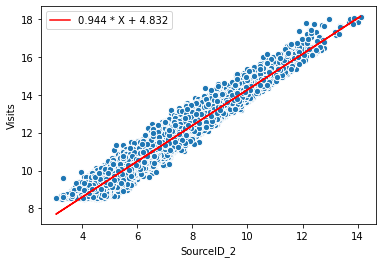

In [35]:
# show the linear regression line
regr,x,y = regres['SourceID_2']
plt.scatter(x, y, edgecolors='white', s = 40)
plt.plot(x, regr.predict(x), color='red', label= f'{round(regr.coef_[0],3)} * X + {round(regr.intercept_,3)}')
plt.xlabel('SourceID_2')
plt.ylabel('Visits')
plt.legend()

## polynomial regression

In [36]:
# for each source build polynomial regression model
for source in ['SourceID_1','SourceID_2','SourceID_3']: 
    _, x, y = regres[source]
    x = x.squeeze()
    for i in range(1,6):
        p_order = np.poly1d(np.polyfit(x, y,i))
        y_pred =  p_order(x)
        r2 = round(r2_score(y, y_pred),3)
        mse = round(((y_pred - y)**2).mean(),3)
        print(source,'order_'+str(i),r2,mse)
    print("||||||||||||||||||||||||||||||||||||||")

SourceID_1 order_1 0.897 0.327
SourceID_1 order_2 0.902 0.312
SourceID_1 order_3 0.906 0.3
SourceID_1 order_4 0.907 0.296
SourceID_1 order_5 0.907 0.296
||||||||||||||||||||||||||||||||||||||
SourceID_2 order_1 0.936 0.202
SourceID_2 order_2 0.937 0.199
SourceID_2 order_3 0.938 0.196
SourceID_2 order_4 0.938 0.194
SourceID_2 order_5 0.939 0.194
||||||||||||||||||||||||||||||||||||||
SourceID_3 order_1 0.965 0.139
SourceID_3 order_2 0.965 0.137
SourceID_3 order_3 0.967 0.131
SourceID_3 order_4 0.967 0.131
SourceID_3 order_5 0.968 0.128
||||||||||||||||||||||||||||||||||||||


### conclusion 

- All 3 users can be used to estimate the learning set with good results, r^2 score above 0.89.

- User 3 has the best r^2 score (0.965) and the least mse score (0.139), so he the best estimator. But he visit the least number of sites, and can be used only for those sites.
- User 1 on the other hand can be used to estimate 90% of the sites but his result are not the best.
- A polynomial regression model showed no improvement, as can be expected, from the plot of the dots that shows Linear relations

## Use all three sources - Multiple Regression

In [37]:
df_clean = mergedDf_log.dropna()
df_clean.shape

(2932, 6)

In [38]:
X = df_clean[['SourceID_1', 'SourceID_2','SourceID_3']]
Y = df_clean['Visits']

regr = linear_model.LinearRegression()
regr.fit(X, Y)
Y_pred = regr.predict(X) 

Source = 'SourceID_1_2_3'
coef = [round(x,3)for x in regr.coef_]
r2 = round(r2_score(Y, Y_pred),3)
mse = round(((Y_pred - Y)**2).mean(),3)
n_sites = X.shape[0]

df = show_results(regr,X,Y,10)
df

,Y,Y_pred
1738,11.682,11.724
179,14.157,13.889
4400,9.942,9.864
4234,10.176,10.299
481,11.110,11.298
447,11.228,11.782
3102,14.893,14.986
8720,12.592,12.958
888,10.621,10.833
9283,10.554,10.655


In [39]:
# comparison between all the models prediction, and metrics.
i = df.index.to_list()
for s in ['SourceID_1', 'SourceID_2','SourceID_3']:
    df[s] = show_results(*regres[s], indexes=i)['Y_pred']
df.rename(columns={'Y_pred':'SourceID_1_2_3'})

,Y,SourceID_1_2_3,SourceID_1,SourceID_2,SourceID_3
1738,11.682,11.724,12.141,11.981,11.350
179,14.157,13.889,13.982,14.290,13.400
4400,9.942,9.864,9.399,9.343,10.494
4234,10.176,10.299,10.706,10.037,10.372
481,11.110,11.298,10.784,11.494,11.375
447,11.228,11.782,11.867,11.703,11.762
3102,14.893,14.986,14.425,14.429,15.319
8720,12.592,12.958,12.911,13.120,12.749
888,10.621,10.833,10.454,11.012,10.898
9283,10.554,10.655,11.046,10.103,10.900


In [40]:
scores_Regression = scores_Regression.append({'Source':Source, 'coef':coef,'intercept':round(regr.intercept_,3),'r2_score':r2,'mse':mse, '# sites':n_sites}, ignore_index=True)
scores_Regression

,Source,coef,intercept,r2_score,mse,# sites
0,SourceID_1,0.905,5.308,0.897,0.327,8502
1,SourceID_2,0.944,4.832,0.936,0.202,6736
2,SourceID_3,0.968,4.789,0.965,0.139,3414
3,SourceID_1_2_3,"[0.185, 0.312, 0.484]",4.682,0.975,0.083,2932


## The Missing Sites

(695, 4)


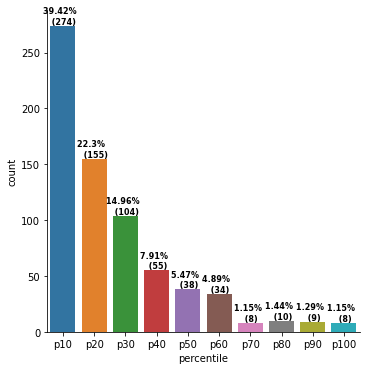

In [41]:
users_sites = sources_df['Site'].to_list()
flt = LSet_df['Site'].isin(users_sites)
users_missing_sites = LSet_df.loc[~flt]
print(users_missing_sites.shape)
total_sites = users_missing_sites.shape[0]
g = sns.catplot(kind='count', x='percentile', data=users_missing_sites, order=['p10','p20','p30','p40','p50','p60','p70','p80','p90','p100',])

for rect in g.ax.patches:
    height = rect.get_height()
    percentage = round(height/total_sites * 100.0, 2)
    x = rect.get_x() + rect.get_width()/2.0
    plt.text(x, height, f'{percentage}%  \n ({height})', ha='center', va='bottom',fontweight='bold', size=8,color='black')


### conclusion 

- using all 3 users improve the estimator to: r^2 score- 0.975 and mse score- 0.083. The down side, it can be apply only on 2932 sites from total of 9699.

- The missing 695 sites (No user has visited them) - most of them are sites with a low number of visits.